In [1]:
import chainer
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import PIL

In [2]:
chainer.cuda.get_device_from_id(0).use()

In [3]:
# download pretrained resnet50 from 'https://github.com/KaimingHe/deep-residual-networks'
# (One Drive link: https://onedrive.live.com/?authkey=%21AAFW2-FVoxeVRck&id=4006CBB8476FF777%2117887&cid=4006CBB8476FF777) )
# and place it on /home/ubuntu/.chainer/dataset/pfnet/chainer/models/ResNet-50-model.caffemodel

In [4]:
data = '../../data/kaggle/dogs-vs-cats-redux-kernels-edition/'    
path_train = os.path.join(data, 'train')
all_images = os.listdir(path_train)
all_labels = np.asarray(['cat' in x for x in all_images], dtype=np.int32)
full_dataset = chainer.datasets.LabeledImageDataset(zip(all_images, all_labels), root=path_train)

def Resize(size):
    def transform((image, label)):
        image = PIL.Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8))
        image = image.resize(size, PIL.Image.NEAREST)
        return (np.asarray(image).transpose(2, 0, 1).astype(np.float32), label)
    return transform

full_dataset = chainer.datasets.TransformDataset(full_dataset, Resize((224, 224)))
train_dataset, valid_dataset = chainer.datasets.split_dataset_random(full_dataset,
                                                                     first_size=int(len(full_dataset)*0.8),
                                                                     seed=42)

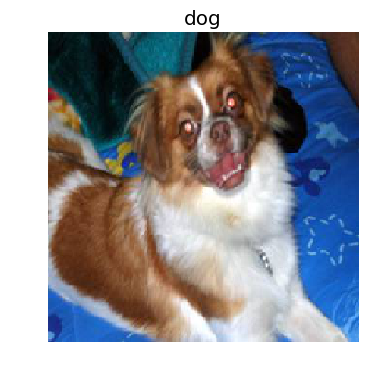

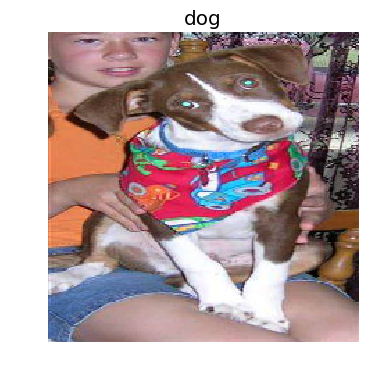

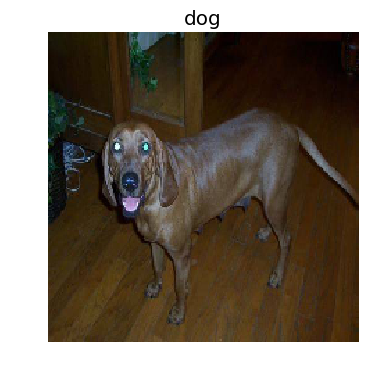

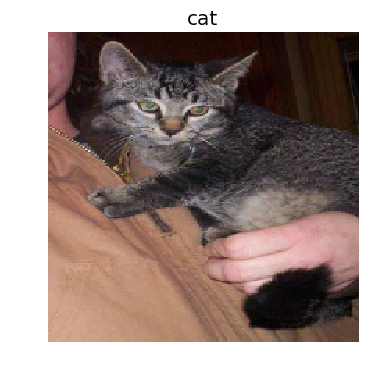

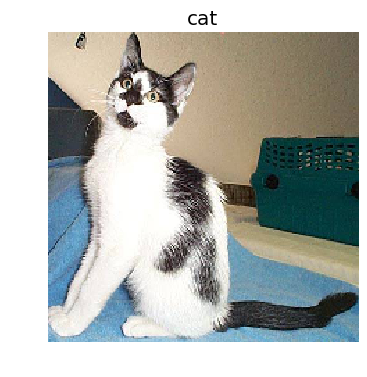

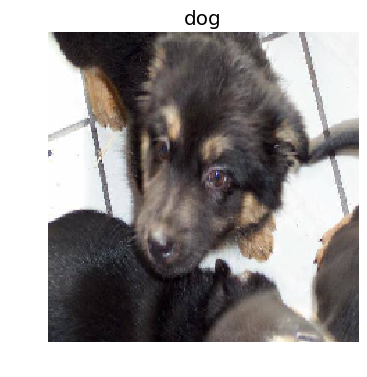

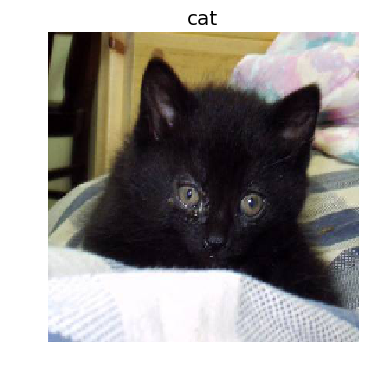

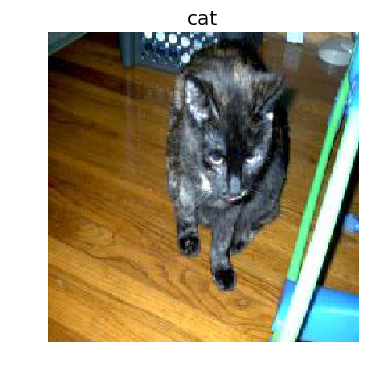

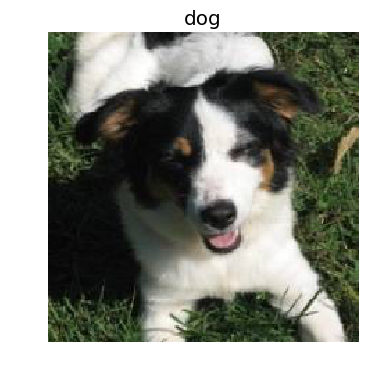

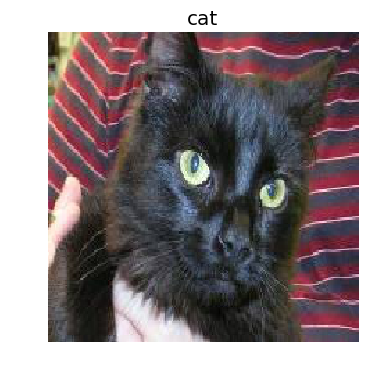

In [5]:
def string_of_label(label):
    """Note that this is opposite to the Kaggle convention."""
    return ['dog', 'cat'][label]

for i in range(10):
    image, label = train_dataset[i]
    image = np.transpose(image, (1, 2, 0)) / 255.
    plt.figure()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.title(string_of_label(label))

In [6]:
class CatDogResNet50(chainer.Chain):
    def __init__(self):
        super(CatDogResNet50, self).__init__()
        with self.init_scope():
            self.resnet50 = chainer.links.ResNet50Layers()
            self.fc_final = chainer.links.Linear(None, 2)
    def __call__(self, x):
        with chainer.no_backprop_mode():
            y = self.resnet50(x, layers=['pool5'])['pool5']
        return self.fc_final(y)

In [ ]:
train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size=64, shuffle=True)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size=128, repeat=False, shuffle=False)

resnet = CatDogResNet50()

# Load model trained in a first run. Comment out this line if starting from scratch.
#chainer.serializers.load_npz('model-210.npz', resnet)

model = chainer.links.Classifier(resnet)
model.to_gpu()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=0)

In [19]:
trigger = (2, 'iteration')

trainer = chainer.training.Trainer(updater, (10, 'epoch'), out='result2')
trainer.extend(chainer.training.extensions.Evaluator(test_iter, model, device=0),
               trigger=(100, 'iteration'))
trainer.extend(chainer.training.extensions.LogReport(trigger=trigger))
trainer.extend(chainer.training.extensions.PrintReport([
            'elapsed_time',
            'epoch', 'iteration',
            'main/accuracy', 'validation/main/accuracy',
            'main/loss', 'validation/main/loss']), trigger=trigger)
trainer.extend(
    chainer.training.extensions.PlotReport(['main/loss', 'validation/main/loss'],
                             trigger=trigger, file_name='loss.png'))
trainer.extend(
    chainer.training.extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                             trigger=trigger, file_name='accuracy.png'))
# this saves the complete trainer object
trainer.extend(chainer.training.extensions.snapshot(),
               trigger=(1, 'epoch'))
# this saves only the resnet model (hopefuly)
trainer.extend(chainer.training.extensions.snapshot_object(model.predictor, 'snapshot_model_{.updater.iteration}' ),
               trigger=chainer.training.triggers.MinValueTrigger('validation/main/loss', trigger=(100, 'iteration')))

# restart from a saved point
chainer.serializers.load_npz('result2/snapshot_iter_1600', trainer)

trainer.run()

elapsed_time  epoch       iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
1.86356       1           314         0.984375                                 0.0633416                         
5.70907       1           316         0.976562                                 0.0597441                         
9.42672       1           318         0.992188                                 0.052181                          
13.267        1           320         0.953125                                 0.128049                          
17.096        1           322         0.945312                                 0.110674                          
20.8741       1           324         0.976562                                 0.0660275                         
24.7544       1           326         0.945312                                 0.121259                          
28.6425       1           328         0.976562                                 0.054849   

KeyboardInterrupt: 

In [20]:
chainer.serializers.save_npz('model-1600.npz', model.predictor)